In [1]:
import tensorflow as tf
import numpy as np

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import glob, os, sys
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):
    with open(filename, 'rb') as fp:
        return pickle.load(fp)

In [3]:
from keras import backend as K
from keras.preprocessing import image
import skimage
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras import optimizers

from sklearn.model_selection import train_test_split

from keras.applications.resnet50 import ResNet50 as resnet
from keras.applications.resnet50 import preprocess_input as resnet_pp

from keras.optimizers import Adam

def normalize(a):
    return (a - np.min(a))/np.ptp(a)

Using TensorFlow backend.


In [4]:
main_path = os.path.abspath("D:/data/POETdataset/PascalImages/")
classes = ['dog', 'sofa', 'cat']
IMG_SIZE = 224
PATCH_WIDTH=28
T = int(IMG_SIZE/PATCH_WIDTH)**2

new_dir = 'soft_attention_features'
new_dir_img = 'soft_attention_images'

files_list = [glob.glob(os.path.join(main_path, '%s*' %class_)) for class_ in classes]
files_dict = {class_name.replace('*', ''): class_files for class_name, class_files in zip(classes, files_list)}

In [5]:
# Build a model by adding preprocessing before the pretrained CNN
def get_feature_extraction_model(img_size):
    cnn_object, pp_function = _get_pretrained_model()
    model = keras.models.Sequential()
    cnn_model = cnn_object(weights='imagenet', include_top=False, pooling='max')
    model.add(keras.layers.Lambda(pp_function, name='preprocessing', input_shape=(img_size, img_size, 3)))
    model.add(cnn_model)
    return model

# Unpacking information from the models dictionary
def _get_pretrained_model():
    cnn_object = resnet
    pp_function = resnet_pp
    return cnn_object, pp_function

def _get_patches(x, patch_width):
    patches = np.squeeze(np.asarray(skimage.util.view_as_windows(x, window_shape=(1,patch_width,patch_width,3), 
                                                                 step=(1,patch_width,patch_width,3)), dtype=np.int))
    print(patches.shape)
    patches = patches.reshape(x.shape[0], int(IMG_SIZE/patch_width)**2, patch_width, patch_width, 3)
    return patches

def _load_images(files):
    return np.asarray([image.img_to_array(image.load_img(file, target_size=(IMG_SIZE, IMG_SIZE))) for file in files], dtype=np.int)

def get_features(files, model, patch_width):
    # Load images based on the size of the Lambda layer 
    # provided as the first layer before the pretrained CNN
    x = _load_images(files)
    patches = _get_patches(x, patch_width = patch_width)
    patches_shape = patches.shape
    features = model.predict(patches.reshape(-1, patch_width, patch_width, 3), verbose=1)
    print(features.shape)
    return features.reshape(patches_shape[0], patches_shape[1], 2048)

Patch feature extraction

In [6]:
model = get_feature_extraction_model(img_size = PATCH_WIDTH)

In [7]:
for files in files_list:
    assert len(files) > 0
    
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

for class_number, (class_name, files) in enumerate(files_dict.items()):
    print(class_name)
    features = get_features(files, model, PATCH_WIDTH)
    print(features.shape)
    save_object(features, new_dir + os.path.sep + class_name+'_features.pkl')

dog
(1257, 8, 8, 28, 28, 3)
80448/80448 [==============================] - 71s 880us/step
(80448, 2048)
(1257, 64, 2048)
sofa
(467, 8, 8, 28, 28, 3)
29888/29888 [==============================] - 25s 844us/step
(29888, 2048)
(467, 64, 2048)
cat
(1051, 8, 8, 28, 28, 3)
67264/67264 [==============================] - 57s 849us/step
(67264, 2048)
(1051, 64, 2048)


In [8]:
if not os.path.exists(new_dir_img):
    os.makedirs(new_dir_img)
    
for class_number, (class_name, files) in enumerate(files_dict.items()):
    print(class_name)
#     features = get_features(files, model, PATCH_WIDTH)
#     print(features.shape)
    images = _load_images(files)
    print(images.shape)
    save_object(images, new_dir_img + os.path.sep + class_name + '.pkl')

dog
(1257, 224, 224, 3)
sofa
(467, 224, 224, 3)
cat
(1051, 224, 224, 3)


In [9]:
X = []
y = []
org_images = []
for class_number, (class_name, files) in enumerate(files_dict.items()):
    classfeatures_path = os.path.abspath(os.path.join('.', new_dir, class_name + '_features.pkl'))
    classimages_path = os.path.abspath(os.path.join('.', new_dir_img, class_name + '.pkl'))
    print(classfeatures_path)
    features = load_object(classfeatures_path).reshape(-1,T,2048)
    images = load_object(classimages_path)
    org_images.append(images)
    print(features.shape)
    X.append(features)
    y.append([class_number] * features.shape[0])
    
X = np.concatenate(X)
y = np.concatenate(y)
y = keras.utils.to_categorical(y)
org_images = np.concatenate(org_images)
X.shape, y.shape, org_images.shape

D:\data\cogsci3\soft_attention_features\dog_features.pkl
(1257, 64, 2048)
D:\data\cogsci3\soft_attention_features\sofa_features.pkl
(467, 64, 2048)
D:\data\cogsci3\soft_attention_features\cat_features.pkl
(1051, 64, 2048)


((2775, 64, 2048), (2775, 3), (2775, 224, 224, 3))

In [10]:
org_images[0].shape

(224, 224, 3)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2497, 64, 2048), (2497, 3), (278, 64, 2048), (278, 3))

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
sss.get_n_splits(X, y)

train_index, test_index = next(sss.split(X, y))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

X_train.shape, y_train.shape, X_test.shape, y_test.shape, len(train_index), len(test_index)

((2497, 64, 2048), (2497, 3), (278, 64, 2048), (278, 3), 2497, 278)

In [14]:
dense_model = Sequential()
dense_model.add(LSTM(6))
dense_model.add(Dense(units=128, activation='relu', input_shape=(2048,)))
dense_model.add(Dropout(0.25))
dense_model.add(Dense(units=3, activation='softmax'))

dense_model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

history = dense_model.fit(X_train,y_train,
                    batch_size = 32,
                    epochs = 100,
                    validation_data=(X_test, y_test))

Train on 2497 samples, validate on 278 samples
Epoch 1/100
2497/2497 [==============================] - 12s 5ms/step - loss: 1.0242 - acc: 0.4533 - val_loss: 1.0153 - val_acc: 0.4460
Epoch 2/100
2497/2497 [==============================] - 10s 4ms/step - loss: 0.9869 - acc: 0.4866 - val_loss: 0.9957 - val_acc: 0.4604
Epoch 3/100
2497/2497 [==============================] - 10s 4ms/step - loss: 0.9687 - acc: 0.5038 - val_loss: 1.0239 - val_acc: 0.4676
Epoch 4/100
2497/2497 [==============================] - 10s 4ms/step - loss: 0.9585 - acc: 0.5310 - val_loss: 1.0131 - val_acc: 0.4353
Epoch 5/100
2497/2497 [==============================] - 10s 4ms/step - loss: 0.9414 - acc: 0.5390 - val_loss: 1.0410 - val_acc: 0.4568
Epoch 6/100
2497/2497 [==============================] - 10s 4ms/step - loss: 0.9269 - acc: 0.5575 - val_loss: 1.0301 - val_acc: 0.4496
Epoch 7/100
2497/2497 [==============================] - 10s 4ms/step - loss: 0.9199 - acc: 0.5639 - val_loss: 1.0390 - val_acc: 0.4424
E

KeyboardInterrupt: 

In [15]:
np.max(X_train[0]), np.min(X_train[0])

(63.522808, -9.429194)

In [143]:
NUM_CHANNELS = 1
n_epochs = 50
batch_size = 32
T = 64
lstm_time = 3 #analogous to fixations ?

def _get_initial_lstm(features, H, D=2048):
    with tf.variable_scope('initial_lstm'):
        features_mean = tf.reduce_mean(features, 1)

        w_h = tf.get_variable('w_h', [D, H])
        b_h = tf.get_variable('b_h', [H])
        h = tf.nn.tanh(tf.matmul(tf.ones_like(features_mean), w_h) + b_h)

        w_c = tf.get_variable('w_c', [D, H])
        b_c = tf.get_variable('b_c', [H])
        c = tf.nn.tanh(tf.matmul(tf.ones_like(features_mean), w_c) + b_c)
        return c, h

tf.reset_default_graph()

X_input = tf.placeholder(tf.float32, [None, T, 2048], name='X')
labels = tf.placeholder(tf.int32, [None, y_train.shape[1]], name='labels')

rnn_units = 32

c,h = _get_initial_lstm(X_input[:,:,:], H=rnn_units)

# context = tf.ones_like(X_input[:,0,:], dtype=np.float32)
context = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), 3, activation='relu')
# context = tf.layers.dense(context, 2048, activation='tanh')
# context = tf.nn.softmax(context)

# att = tf.ones_like(X_input[:,:,0], dtype=np.float32)
# att = tf.nn.softmax(att)

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=rnn_units)

c_s = []
h_s = []
attentions = []
for t in range(lstm_time):
    # encoded lstm context to a specific size 
    context = tf.layers.dense(context, 2048, activation='tanh')
    # squeeze the features sfrom REsnet
    att_input = tf.nn.tanh(X_input)
    # how lstm context and patch info relate
    att = tf.einsum('bi,bti->bt', context, att_input)
    att = tf.nn.softmax(att)
#     att = tf.layers.dense(tf.reshape(tf.concat( [X_input[:,:,:], context], axis=1), t)
    
    lstm_input = tf.einsum('bt,bti->bi', att, X_input[:,:,:])
    
    context, (c, h) = lstm_cell(inputs=lstm_input, state=[c, h])
    c_s.append(c)
    h_s.append(h)
    attentions.append(att)

# basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_units)
# outputs, states = tf.nn.dynamic_rnn(basic_cell, X_input, dtype=tf.float32)
# outputs = tf.reshape(outputs, shape=(tf.shape(outputs)[0] * tf.shape(outputs)[1], rnn_units))

# outputs = tf.reduce_sum(outputs, axis=1)
# weights = tf.ones_like(pool2_flat)
# weights = tf.nn.softmax(weights)

# outputs = tf.redu

# pool2_flat = tf.einsum('ijk, ijk->ik', weights, X)
dense = tf.layers.dense(inputs=h, units=128, activation=tf.nn.relu)

# Logits Layer
logits = tf.layers.dense(inputs=dense, units=y_train.shape[1])

classes = tf.argmax(logits, axis=1)
probabilites = tf.nn.softmax(logits, name="softmax_tensor")

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize(
    loss=loss,
    global_step=tf.train.get_global_step()
)

accuracy = tf.reduce_mean(tf.cast(tf.equal(classes, tf.argmax(labels, 1)), tf.float32))

init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [144]:
X_input.shape

TensorShape([Dimension(None), Dimension(64), Dimension(2048)])

In [145]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
# X_train.shape, y_train.shape, X_test.shape, y_test.shape


with tf.Session() as sess:
    sess.run(init_g)
    sess.run(init_l)
    
        # Training cycle
    for epoch in range(n_epochs):
        print("Epoch:", epoch)
        train_loss = []
        for b in range(0, X_train.shape[0], batch_size):
            _, acc = sess.run([train_op, accuracy], feed_dict={
                                                            X_input: X_train[b:b+batch_size],
                                                            labels: y_train[b:b+batch_size]
                                                        })
#             print(acc)
        
        _, acc, c_s_, h_s_, context_, atts_, test_proba_ = sess.run([train_op, accuracy, c_s, h_s, context, attentions, probabilites], feed_dict={
                                                X_input: X_test,
                                                labels: y_test
                                            })
        print(acc)
#         print(atts_[0])

Epoch: 0
0.54316545
Epoch: 1
0.58633095
Epoch: 2
0.60431653
Epoch: 3
0.6223022
Epoch: 4
0.64028776
Epoch: 5
0.67266184
Epoch: 6
0.68705034
Epoch: 7
0.6906475
Epoch: 8
0.70863307
Epoch: 9
0.7122302
Epoch: 10
0.7338129
Epoch: 11
0.7661871
Epoch: 12
0.8021583
Epoch: 13
0.8021583
Epoch: 14
0.81654674
Epoch: 15
0.82733816
Epoch: 16
0.8345324
Epoch: 17
0.84532374
Epoch: 18
0.86690646
Epoch: 19
0.8489209
Epoch: 20
0.8848921
Epoch: 21
0.85251796
Epoch: 22
0.85971224
Epoch: 23
0.85251796
Epoch: 24
0.8776978
Epoch: 25
0.8776978
Epoch: 26
0.8884892
Epoch: 27
0.89568347
Epoch: 28
0.9028777
Epoch: 29
0.89568347
Epoch: 30
0.91007197
Epoch: 31
0.91007197
Epoch: 32
0.92805755
Epoch: 33
0.9244604
Epoch: 34
0.92086333
Epoch: 35
0.9172662
Epoch: 36
0.89928055
Epoch: 37
0.9244604
Epoch: 38
0.9244604
Epoch: 39
0.9172662
Epoch: 40
0.92086333
Epoch: 41
0.92805755
Epoch: 42
0.9244604
Epoch: 43
0.9316547
Epoch: 44
0.9352518
Epoch: 45
0.9244604
Epoch: 46
0.9388489
Epoch: 47
0.9388489
Epoch: 48
0.9532374
Epoch: 

In [146]:
np.array(c_s_).shape, np.array(h_s_).shape, np.array(context_).shape, np.array(atts_).shape

((3, 278, 32), (3, 278, 32), (278, 32), (3, 278, 64))

Note to self:

I need to use lstm cell (building block) instead of dynamic rnn (unrolled rnn) like here:

    for t in range(self.T):
            context, alpha = self._attention_layer(features, features_proj, h, reuse=(t!=0))
            alpha_list.append(alpha)

            if self.selector:
                context, beta = self._selector(context, h, reuse=(t!=0))

            with tf.variable_scope('lstm', reuse=(t!=0)):
                _, (c, h) = lstm_cell(inputs=tf.concat( [x[:,t,:], context],1), state=[c, h])

            logits = self._decode_lstm(x[:,t,:], h, context, dropout=self.dropout, reuse=(t!=0))

            loss += tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=captions_out[:, t],logits=logits)*mask[:, t] )
            
So that I can take the output of the lstm at each step and feed it to my attention network

In [147]:
atts_ = np.array(atts_)

In [148]:
def get_att(t, n):
    return atts_[t, n, :]

# plt.scget_att(0, 0)

In [149]:
org_images = np.array(org_images)

In [150]:
org_images.shape

(2775, 224, 224, 3)

In [151]:
atts_.shape

(3, 278, 64)

[0.95358735 0.02037047 0.02604212]
dog


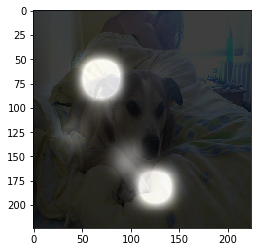

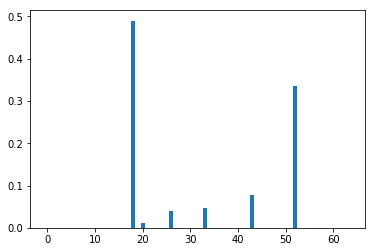

[0.95358735 0.02037047 0.02604212]
dog


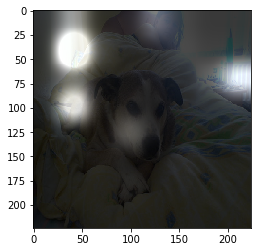

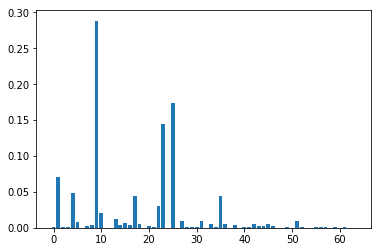

[0.95358735 0.02037047 0.02604212]
dog


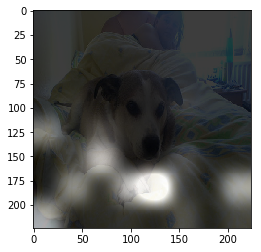

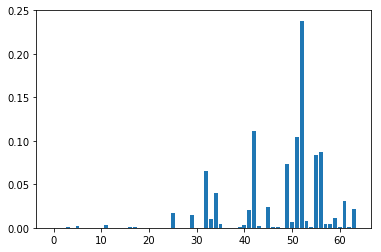

In [158]:
from scipy import signal
from scipy import ndimage

image_n = 19
for t in range(atts_.shape[0]):
    img_index = test_index[image_n]
    proba_res = test_proba_[image_n]
    print(proba_res)
    print(np.array(['dog', 'sofa', 'cat'])[np.argmax(proba_res)])
    
    chosen_img = org_images[img_index].copy()
    chosen_attention = get_att(t,image_n)
    attended_patch = np.argmax(chosen_attention)
    
#     plt.imshow(chosen_img)
#     plt.show()
    
    result = np.zeros_like(chosen_img)
    for attended_patch_n in range(T):
        att_prob = chosen_attention[attended_patch_n]
#         print(att_prob)
#         print(attended_patch)
#         print(attended_patch_n/(IMG_SIZE/PATCH_WIDTH))
#         print(int(attended_patch%(IMG_SIZE/PATCH_WIDTH)))
        row = int(attended_patch_n/(IMG_SIZE/PATCH_WIDTH))
        col = int(attended_patch_n%(IMG_SIZE/PATCH_WIDTH))
#         print(row, col)
        from_y = row*PATCH_WIDTH
        to_y = from_y+PATCH_WIDTH

        from_x = col*PATCH_WIDTH
        to_x = from_x+PATCH_WIDTH
#         print(from_x, from_y)
        result[from_y:to_y, from_x:to_x, :] = np.ones_like(result[from_x:to_x,from_y:to_y,:]) * 255 * att_prob
    
#         cropped_img = chosen_img[from_x:to_x,
#                     from_y:to_y,:]
#         chosen_img[from_x:to_x,
#                     from_y:to_y,:] = cropped_img * att_prob + 100
#         print(adjusted_img.shape)

    
#     scharr = np.array([[ 0, 0,  0],
#                        [0, 1, 0],
#                        [ 0, 0,  0]]) # Gx + j*Gy
#     adjusted_img = signal.convolve2d(adjusted_img[:,:,0], scharr, boundary='symm', mode='same')
#     print(adjusted_img.max())
#     plt.imshow(chosen_img)
#     plt.show()
    
    result = result / 255.
    chosen_img = chosen_img / 255.
    result = ndimage.gaussian_filter(result, sigma=8) * 8
    result[result > 1] = 1
    res = normalize(0.3 * chosen_img + result)
    plt.imshow(res)
    plt.show()
    
    plt.bar(range(atts_.shape[2]), chosen_attention)
    plt.show()

In [24]:
np.max(result)

0.9127983833476463

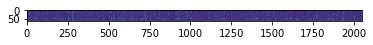

In [25]:
plt.imshow(X_test[image_n])

# SHap

In [159]:
import json
import shap

In [160]:
to_explain = org_images[[5,4]]

In [172]:
atts_[0].shape

(278, 64)

In [173]:
chosen_attention = get_att(2,15)

In [178]:
c_s, h_s, context, attentions, probabilites

([<tf.Tensor 'basic_lstm_cell/Add_1:0' shape=(?, 32) dtype=float32>,
  <tf.Tensor 'basic_lstm_cell/Add_3:0' shape=(?, 32) dtype=float32>,
  <tf.Tensor 'basic_lstm_cell/Add_5:0' shape=(?, 32) dtype=float32>],
 [<tf.Tensor 'basic_lstm_cell/Mul_2:0' shape=(?, 32) dtype=float32>,
  <tf.Tensor 'basic_lstm_cell/Mul_5:0' shape=(?, 32) dtype=float32>,
  <tf.Tensor 'basic_lstm_cell/Mul_8:0' shape=(?, 32) dtype=float32>],
 <tf.Tensor 'basic_lstm_cell/Mul_8:0' shape=(?, 32) dtype=float32>,
 [<tf.Tensor 'Softmax:0' shape=(?, 64) dtype=float32>,
  <tf.Tensor 'Softmax_1:0' shape=(?, 64) dtype=float32>,
  <tf.Tensor 'Softmax_2:0' shape=(?, 64) dtype=float32>],
 <tf.Tensor 'softmax_tensor:0' shape=(?, 3) dtype=float32>)

In [182]:
explainer = shap.DeepExplainer(tf.Session().run(c_s[-1]), to_explain)

InvalidArgumentError: You must feed a value for placeholder tensor 'X' with dtype float and shape [?,64,2048]
	 [[{{node X}} = Placeholder[dtype=DT_FLOAT, shape=[?,64,2048], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node basic_lstm_cell/Add_5/_1}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_253_basic_lstm_cell/Add_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'X', defined at:
  File "C:\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Anaconda3\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-143-95c836c1b09f>", line 22, in <module>
    X_input = tf.placeholder(tf.float32, [None, T, 2048], name='X')
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1745, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 5020, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3272, in create_op
    op_def=op_def)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'X' with dtype float and shape [?,64,2048]
	 [[{{node X}} = Placeholder[dtype=DT_FLOAT, shape=[?,64,2048], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node basic_lstm_cell/Add_5/_1}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_253_basic_lstm_cell/Add_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
